In [4]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer


2025-10-05 19:13:55.400760: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759691635.573011      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759691635.623536      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
df_train = pd.read_csv('/kaggle/input/jigsaw-agile-community-rules/train.csv')

print(df_train.shape)
df_train.head()

(2029, 9)


,row_id,body,rule,subreddit,positive_example_1,positive_example_2,negative_example_1,negative_example_2,rule_violation
0,0,Banks don't want you to know this! Click here ...,"No Advertising: Spam, referral links, unsolici...",Futurology,If you could tell your younger self something ...,hunt for lady for jack off in neighbourhood ht...,Watch Golden Globe Awards 2017 Live Online in ...,"DOUBLE CEE x BANDS EPPS - ""BIRDS""\n\nDOWNLOAD/...",0
1,1,SD Stream [ ENG Link 1] (http://www.sportsstre...,"No Advertising: Spam, referral links, unsolici...",soccerstreams,[I wanna kiss you all over! Stunning!](http://...,LOLGA.COM is One of the First Professional Onl...,#Rapper \n🚨Straight Outta Cross Keys SC 🚨YouTu...,[15 Amazing Hidden Features Of Google Search Y...,0
2,2,Lol. Try appealing the ban and say you won't d...,No legal advice: Do not offer or request legal...,pcmasterrace,Don't break up with him or call the cops. If ...,It'll be dismissed: https://en.wikipedia.org/w...,Where is there a site that still works where y...,Because this statement of his is true. It isn'...,1
3,3,she will come your home open her legs with an...,"No Advertising: Spam, referral links, unsolici...",sex,Selling Tyrande codes for 3€ to paypal. PM. \n...,tight pussy watch for your cock get her at thi...,NSFW(obviously) http://spankbang.com/iy3u/vide...,Good News ::Download WhatsApp 2.16.230 APK for...,1
4,4,code free tyrande --->>> [Imgur](http://i.imgu...,"No Advertising: Spam, referral links, unsolici...",hearthstone,wow!! amazing reminds me of the old days.Well...,seek for lady for sex in around http://p77.pl/...,must be watch movie https://sites.google.com/s...,We're streaming Pokemon Veitnamese Crystal RIG...,1


In [6]:
# set hyperprameters
MODEL_NAME = "microsoft/deberta-v3-base"
MAX_LENGTH = 256
BATCH_SIZE = 8
EPOCHS = 6
LEARNING_RATE = 2e-5
SEED = 42
USE_EXAMPLES = True

In [7]:
df_train = df_train.fillna("")

In [8]:
def build_input_text(row, use_examples=USE_EXAMPLES):
    '''  Build an input string containing the Rule, 
    subreddit, body and examples
    '''
    parts = []
    rule = row.get("rule", "")
    subreddit = row.get("subreddit", "")
    if rule:
        parts.append(f"[RULE] {rule}")
    if subreddit:
        parts.append(f"[SUBREDDIT] {subreddit}")
    # main comment body
    body = row.get("body", "")
    parts.append(f"[COMMENT] {body}")
    if use_examples:
        for ex_col in ["positive_example_1", "positive_example_2", "negative_example_1", "negative_example_2"]:
            ex = row.get(ex_col, "")
            if pd.notna(ex) and ex != "":
                # label them so model can learn from examples
                if "positive" in ex_col:
                    parts.append(f"[POS_EX] {ex}")
                else:
                    parts.append(f"[NEG_EX] {ex}")
    return " ".join(parts)

df_train["text"] = df_train.apply(lambda r: build_input_text(r), axis=1)


In [9]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.softmax(torch.tensor(logits), dim=1).numpy()[:, 1]
    preds = (probs > 0.5).astype(int)

    return {
        "accuracy": accuracy_score(labels, preds),
        "roc_auc": roc_auc_score(labels, probs)
    }


In [10]:
y = df_train["rule_violation"].astype(int).values

In [11]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df_train["text"].tolist(),
    y.tolist(),
    test_size=0.3,
    random_state=SEED,
    stratify=y
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,          
    random_state=SEED,
    stratify=temp_labels
)

In [12]:
print("Train examples:", len(train_texts), "Validation examples:", len(val_texts), "Test examples:", len(test_texts))


Train examples: 1420 Validation examples: 304 Test examples: 305


In [13]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def tokenize_fn(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=MAX_LENGTH)

train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
val_dataset   = Dataset.from_dict({"text": val_texts, "label": val_labels})
test_dataset  = Dataset.from_dict({"text": test_texts, "label":test_labels})

train_dataset = train_dataset.map(tokenize_fn, batched=True)
val_dataset   = val_dataset.map(tokenize_fn, batched=True)
test_dataset  = test_dataset.map(tokenize_fn, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/1420 [00:00<?, ? examples/s]

Map:   0%|          | 0/304 [00:00<?, ? examples/s]

Map:   0%|          | 0/305 [00:00<?, ? examples/s]

In [14]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
output_dir = "./deberta_v3_results"
training_args = TrainingArguments(
    output_dir=output_dir,
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="roc_auc",
    logging_steps=50,
    logging_strategy="epoch",
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    seed=SEED,
    greater_is_better=True,
    report_to="none",
)

In [16]:

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/tmp/ipykernel_36/2208459174.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [17]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Roc Auc
1,0.681000,0.667513,0.601974,0.706710
2,0.624300,0.590974,0.690789,0.783766
3,0.548900,0.529591,0.733553,0.806710
4,0.465800,0.567078,0.759868,0.809870
5,0.398400,0.532936,0.759868,0.838831
6,0.332100,0.534023,0.792763,0.850000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

TrainOutput(global_step=534, training_loss=0.5084036673499404, metrics={'train_runtime': 404.8577, 'train_samples_per_second': 21.044, 'train_steps_per_second': 1.319, 'total_flos': 1120873197035520.0, 'train_loss': 0.5084036673499404, 'epoch': 6.0})

In [18]:
pred_out = trainer.predict(test_dataset)
test_probs = torch.softmax(torch.tensor(pred_out.predictions), dim=1).numpy()[:, 1]
test_preds = (test_probs > 0.5).astype(int)

test_labels = pred_out.label_ids

print("Test ROC-AUC:", roc_auc_score(test_labels, test_probs))
print("Test Accuracy:", accuracy_score(test_labels, test_preds))

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test ROC-AUC: 0.8335483870967743
Test Accuracy: 0.7573770491803279


In [19]:
metrics_history = trainer.state.log_history

# Extract metrics
train_losses = [x["loss"] for x in metrics_history if "loss" in x]
val_losses   = [x["eval_loss"] for x in metrics_history if "eval_loss" in x]
val_roc_auc  = [x["eval_roc_auc"] for x in metrics_history if "eval_roc_auc" in x]


train_steps = list(range(1, len(train_losses)+1))
val_epochs  = list(range(1, len(val_losses)+1))
epochs = list(range(1, len(val_roc_auc) + 1))


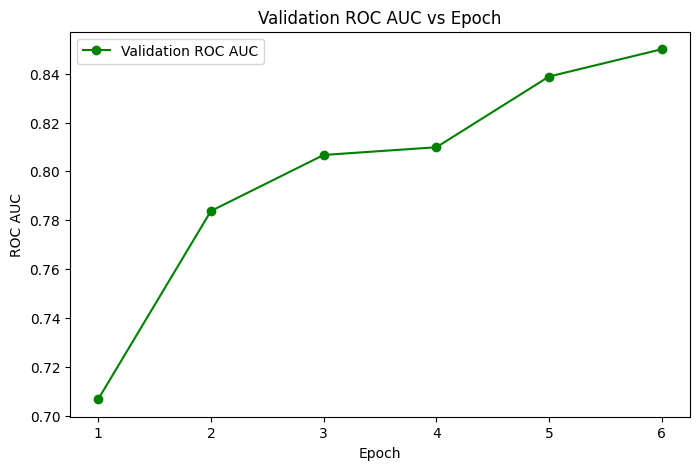

In [20]:

plt.figure(figsize=(8,5))
plt.plot(epochs, val_roc_auc, marker='o', color='green', label="Validation ROC AUC")
plt.xlabel("Epoch")
plt.ylabel("ROC AUC")
plt.title("Validation ROC AUC vs Epoch")
plt.legend()
plt.show()


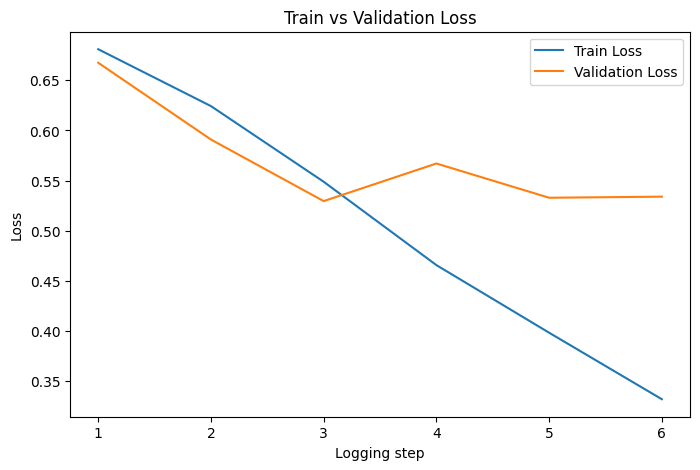

In [21]:
val_losses = [x["eval_loss"] for x in metrics_history if "eval_loss" in x]

plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
plt.xlabel("Logging step")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.show()


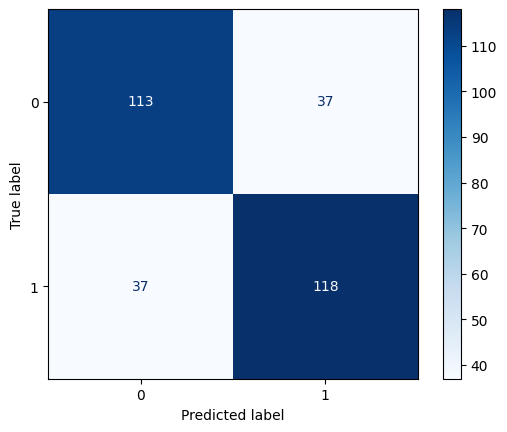

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
disp.plot(cmap="Blues")


In [26]:
# Save model weights and configuration
trainer.save_model("./deberta_v3_trained_v4")
tokenizer.save_pretrained("./deberta_v3_trained_v4")


('./deberta_v3_trained_v4/tokenizer_config.json',
 './deberta_v3_trained_v4/special_tokens_map.json',
 './deberta_v3_trained_v4/spm.model',
 './deberta_v3_trained_v4/added_tokens.json',
 './deberta_v3_trained_v4/tokenizer.json')

In [25]:
import pandas as pd

# Assuming you already have:
# test_preds, test_probs, test_labels

# Create DataFrame
pred_df = pd.DataFrame({
    "true_label": test_labels,
    "pred_label": test_preds,
    "probability": test_probs
})

# Save to CSV
pred_df.to_csv("predictions.csv", index=False)

# For Kaggle download
pred_df.head()


,true_label,pred_label,probability
0,0,0,0.039298
1,1,0,0.076420
2,0,1,0.843492
3,1,0,0.024090
4,0,0,0.366356
